In [25]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.signal import medfilt

In [26]:
var = "wind_speed" #Choose "wind_speed", "current_speed", "combined_wave_index", "total_precipitation", "wave_height", "wave_period"
PSD_dir = "../../../../data/test_correlation/data_mahy"
variable_dir = f"../../../../data/test_correlation/data_soundscape/{var}"
#%matplotlib qt

In [27]:
# Name and unit catalog for each variable
var_info = {
    "wind_speed": ("Wind speed", "m/s"),
    "current_speed": ("Current speed", "m/s"),
    "combined_wave_index": ("Combined wave index", "m/s"),
    "total_precipitation": ("Total precipitation", "m"),
    "wave_height": ("Wave height", "m"),
    "wave_period": ("Wave period", "s"),
}
var_name, unit = var_info.get(var, ("Unknown variable", ""))

In [28]:
# select the stations you want to plot. /!\ You can only choose stations for one hydrophone
selected_stations = ["MAHY01",
                     "MAHY11",
                     "MAHY21",
                     "MAHY31",
                     "MAHY41"
                     ]

hydrophone_number = [station[-1] for station in selected_stations]
# check that only one hydrophone is chosen
if len(set(hydrophone_number))>1:
    raise ValueError("You have selected more than one hydrophone")
else:
    print(f"Hydrophone n°{hydrophone_number[0]} selected")

Hydrophone n°1 selected


In [29]:
# load the PSD data
psds_all = []
for station in selected_stations:
    psd_path = os.path.join(PSD_dir, f"{station}.pkl")
    psds_all.append(pd.read_pickle(psd_path))
# concatenate psds
psd_df = pd.concat(psds_all).sort_index()

# load the variable data
variable_path = os.path.join(variable_dir, f"h{hydrophone_number[0]}.pkl")
variable_df = pd.read_pickle(variable_path)

# keep lines of variable_df only if their date is in psd_df
variable_df = variable_df[variable_df.index.isin(psd_df.index)]

if var == "current_speed":
    # rolling median (== median filter) on a 24h time window
    rolling_median = psd_df.rolling(window="24h", center=True).median()
    # keep only the values matching the variable
    psd_df = rolling_median[rolling_median.index.isin(variable_df.index)]

Text(0.5, 1.0, 'Wind speed overlaid on the spectrogram')

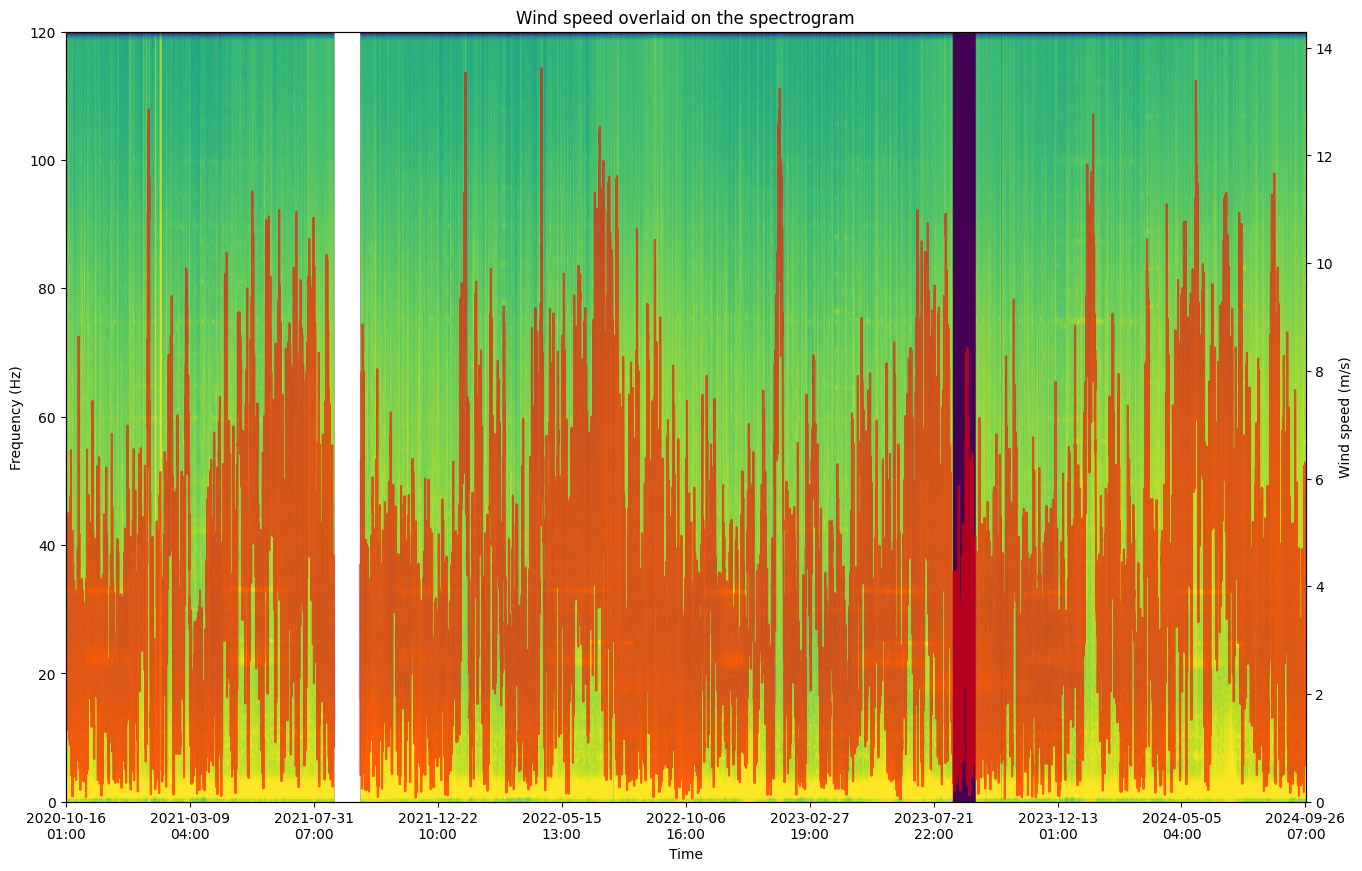

In [30]:
if var == "current_speed":
    full_index = pd.date_range(start=psd_df.index.min(), end=psd_df.index.max(), freq=pd.Timedelta("24h"))
else:
    full_index = pd.date_range(start=psd_df.index.min(), end=psd_df.index.max(), freq=pd.Timedelta("1h"))

psd_reindexed = psd_df.reindex(full_index)
variable_reindexed = variable_df.reindex(full_index)

time_numeric = [t.timestamp() for t in full_index]

fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

sp = ax1.imshow(
    10*np.log10(psd_reindexed.T + 1e-12),
    aspect="auto",
    origin="lower",
    cmap="viridis",
    extent=(time_numeric[0], time_numeric[-1], psd_df.columns[0], psd_df.columns[-1]),
    vmin=10, vmax=95
)

ax2.plot(
    time_numeric,
    variable_reindexed["values"].values,
    color="red",
    alpha=0.6
)

tick_locs = time_numeric[::max(1, len(time_numeric)//10)]
tick_labels = [t.strftime("%Y-%m-%d\n%H:%M") for t in full_index[::max(1, len(full_index)//10)]]
ax1.set_xticks(tick_locs)
ax1.set_xticklabels(tick_labels)
ax2.set_ylim(bottom=0)


ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency (Hz)")
ax2.set_ylabel(f"{var_name} ({unit})")
ax1.set_title(f"{var_name} overlaid on the spectrogram")

In [33]:
# Align common dates (est-ce vraiment nécessaire ?)
common_index = psd_df.index.intersection(variable_df.index)
psd_aligned = psd_df.loc[common_index]
variable_aligned = variable_df.loc[common_index]["values"]

correlations = []

for freq in psd_aligned.columns:
    amplitude = psd_aligned[freq]
    amplitude_filt = medfilt(amplitude, kernel_size=51)
    #NaN filter
    mask = (~np.isnan(amplitude_filt)) & (~np.isnan(variable_aligned))
    if mask.sum() > 2:
        corr = np.corrcoef(amplitude_filt[mask], variable_aligned[mask])[0,1]
    else:
        corr = np.nan
    correlations.append(corr)

frequencies = psd_aligned.columns

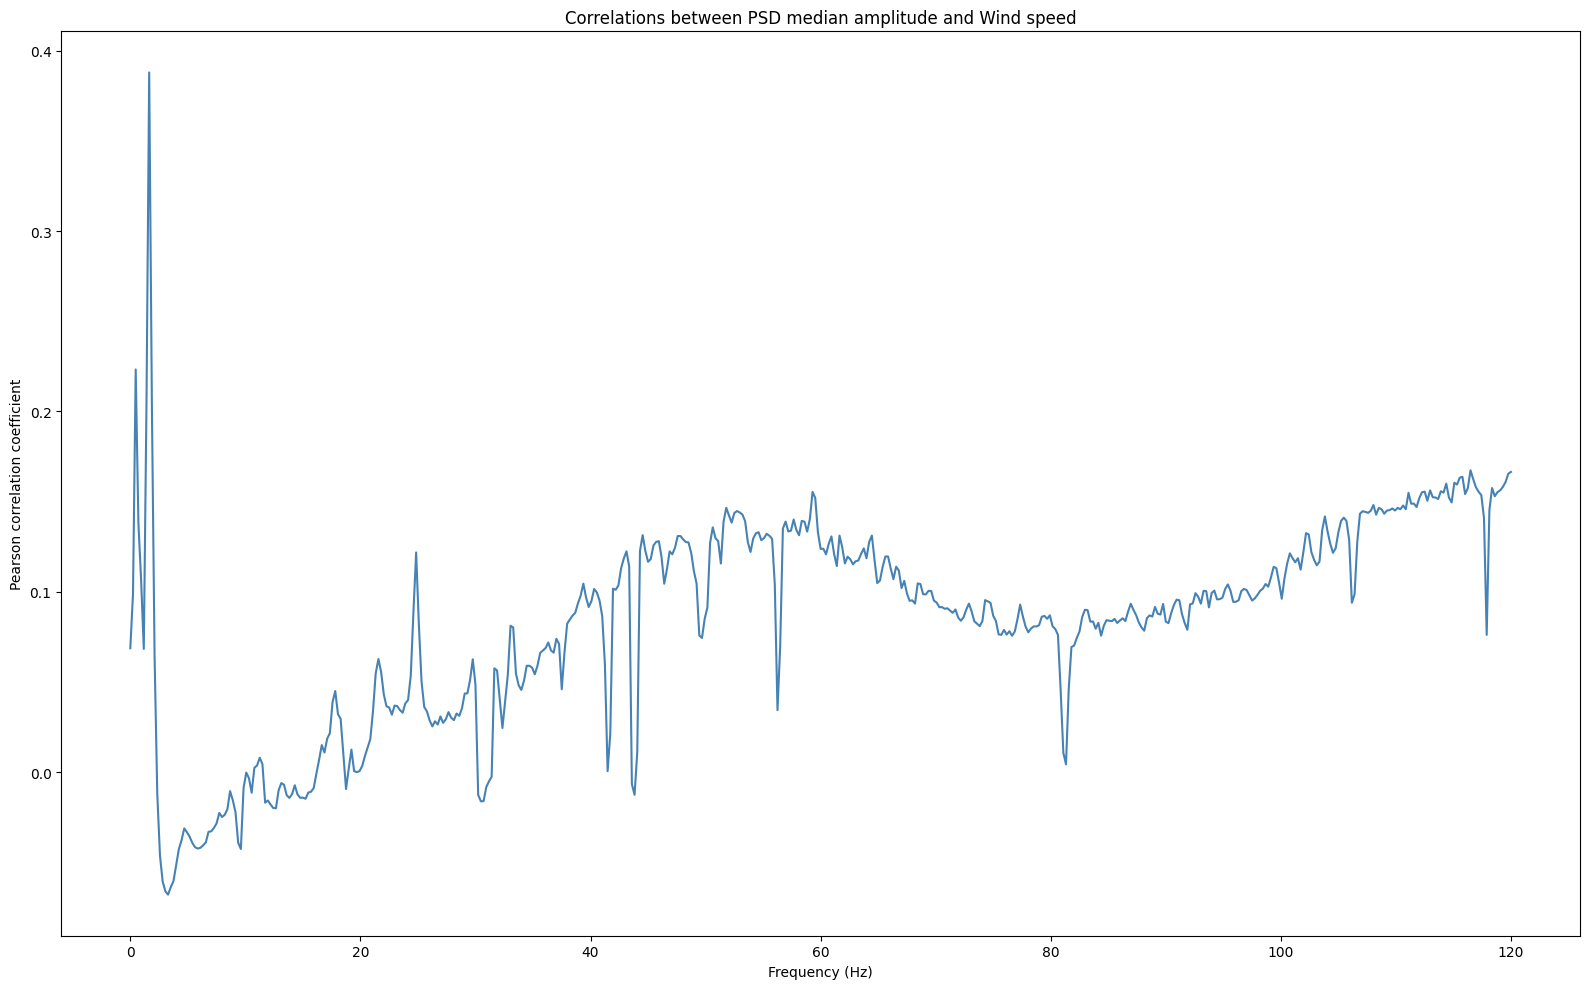

In [34]:
# Plot
plt.figure(figsize=(16,10))
plt.plot(frequencies, correlations, color="steelblue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Pearson correlation coefficient")
plt.title(f"Correlations between PSD median amplitude and {var_name}")

plt.tight_layout()
plt.show()

In [31]:
# # Align common dates (est-ce vraiment nécessaire ?)
# common_index = psd_df.index.intersection(variable_df.index)
# psd_aligned = psd_df.loc[common_index]
# variable_aligned = variable_df.loc[common_index]["values"]
#
# correlations = []
#
# for freq in psd_aligned.columns:
#     amplitude = psd_aligned[freq]
#     #NaN filter
#     mask = (~np.isnan(amplitude)) & (~np.isnan(variable_aligned))
#     if mask.sum() > 2:
#         corr = np.corrcoef(amplitude[mask], variable_aligned[mask])[0,1]
#     else:
#         corr = np.nan
#     correlations.append(corr)
#
# frequencies = psd_aligned.columns

In [32]:
# # Plot
# plt.figure(figsize=(16,10))
# plt.plot(frequencies, correlations, color="steelblue")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Pearson correlation coefficient")
# plt.title(f"Correlations between PSD amplitude and {var_name}")
#
# plt.tight_layout()
# plt.show()